<a href="https://colab.research.google.com/github/adarsh-nl/Mineral-deposits-feature-learning-using-Autoencoder/blob/main/classification_patchWise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 60.6 MB/s eta 0:00:00


Accuracy: 0.6486486486486487
Classification Report:
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       105
           1       1.00      0.19      0.32        80

    accuracy                           0.65       185
   macro avg       0.81      0.59      0.54       185
weighted avg       0.78      0.65      0.57       185



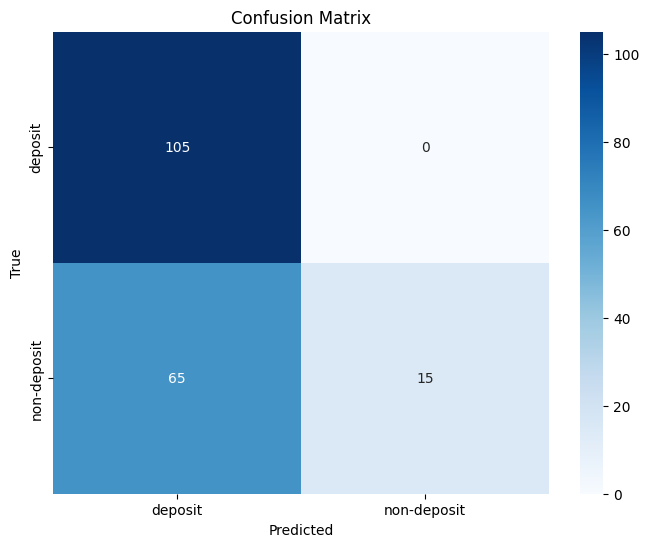

In [2]:
import os
import random
import numpy as np
from PIL import Image
from sklearn import svm
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import rasterio
from sklearn.model_selection import train_test_split

# Define the paths
label_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/Dep_NonDepFinal.tif"
stitched_images_dir = "/content/drive/MyDrive/IITB/Magntic_Image/stitched_outputs_v1"
magnetic_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/MagneticImage.tif"
output_dir = "/content/drive/MyDrive/IITB/Magntic_Image/feature_patches"

# Open the label image using rasterio
with rasterio.open(label_image_path) as label_dataset:
    # Read the label image as a numpy array
    label_image = label_dataset.read(1)  # Assuming label is in the first band

# Define the classes and corresponding pixel values
class_labels = {
    "deposit": 1,
    "non-deposit": 0
}

# Define the sample size
sample_size = 14

# Initialize lists to store the sampled positions
deposit_samples = []
non_deposit_samples = []

# Iterate over the label image and sample positions
for y in range(label_image.shape[0]):
    for x in range(label_image.shape[1]):
        pixel_value = label_image[y, x]
        if pixel_value == class_labels["deposit"]:
            deposit_samples.append((x, y))
        elif pixel_value == class_labels["non-deposit"]:
            non_deposit_samples.append((x, y))

# Randomly select sample positions
deposit_samples = random.sample(deposit_samples, sample_size)
non_deposit_samples = random.sample(non_deposit_samples, sample_size+3)

# Create the output directories
deposit_dir = os.path.join(output_dir, "deposit")
non_deposit_dir = os.path.join(output_dir, "non-deposit")

os.makedirs(deposit_dir, exist_ok=True)
os.makedirs(non_deposit_dir, exist_ok=True)

# Retrieve the image names in the stitched images directory
image_names = os.listdir(stitched_images_dir)

# Iterate over the selected samples
for i, sample_position in enumerate(deposit_samples + non_deposit_samples):
    x, y = sample_position

    # Calculate the patch coordinates
    patch_left = max(0, x - 5)
    patch_upper = max(0, y - 5)
    patch_right = min(label_image.shape[1], x + 5)
    patch_lower = min(label_image.shape[0], y + 5)

    # Iterate over all stitched images
    for image_name in image_names:
        stitched_image_path = os.path.join(stitched_images_dir, image_name)
        stitched_image = Image.open(stitched_image_path)

        # Extract the patch
        patch = stitched_image.crop((patch_left, patch_upper, patch_right, patch_lower))

        # Resize the patch to a consistent size
        patch = patch.resize((100, 100))

        # Determine the class label for the current sample
        if i < sample_size:
            class_label = "deposit"
        else:
            class_label = "non-deposit"

        # Create the subdirectories for the image and layer
        image_dir = os.path.join(output_dir, class_label, f"image_{i}")
        layer_dir = os.path.join(image_dir, f"layer_{image_name[:-4]}")  # Remove the extension from the image name

        os.makedirs(layer_dir, exist_ok=True)
        # Save the patch
        patch_path = os.path.join(layer_dir, f"patch_{image_name[:-4]}.jpg")  # Remove the extension from the image name
        patch.save(patch_path)

# Prepare the feature vectors and labels
features = []
labels = []

for class_label in class_labels.keys():
    class_dir = os.path.join(output_dir, class_label)

    for image_dir in os.listdir(class_dir):
        layer_dir = os.path.join(class_dir, image_dir)
        patch_names = os.listdir(layer_dir)

        for patch_name in patch_names:
            patch_dir = os.path.join(layer_dir, patch_name)
            if os.path.isdir(patch_dir):  # Check if the path is a directory
                patch_files = os.listdir(patch_dir)
                patch_features = []
                for patch_file in patch_files:
                    patch_path = os.path.join(patch_dir, patch_file)
                    if os.path.isfile(patch_path):  # Check if the path is a file
                        patch = Image.open(patch_path)
                        feature_vector = np.array(patch).flatten()
                        patch_features.append(feature_vector)
                features.append(patch_features)
                labels.append(class_labels[class_label])

# Convert the feature vectors and labels to arrays
X = np.array(features)
y = np.array(labels)

# Reshape the feature array to treat each patch as a separate sample
num_patches = X.shape[0]
X = X.reshape(num_patches, -1)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the SVM classifier
classifier = svm.SVC()

# Fit the classifier to the training data
classifier.fit(X_train, y_train)

# Test the classifier and print accuracy
y_pred = classifier.predict(X_test)

# Calculate accuracy
accuracy = (y_pred == y_test).mean()
print("Accuracy:", accuracy)

# Print classification report
from sklearn.metrics import classification_report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap="Blues", fmt="d", xticklabels=class_labels.keys(), yticklabels=class_labels.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
import os
import numpy as np
from PIL import Image
from sklearn import svm
import rasterio

# Define the paths
label_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/Dep_NonDepFinal.tif"
magnetic_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/MagneticImage.tif"
output_dir = "/content/classified_patches"

# Open the label image using rasterio
with rasterio.open(label_image_path) as label_dataset:
    # Read the label image as a numpy array
    label_image = label_dataset.read(1)  # Assuming label is in the first band

# Open the magnetic image dataset
with rasterio.open(magnetic_image_path) as magnetic_dataset:
    # Read the magnetic image as a numpy array
    magnetic_image = magnetic_dataset.read(1)

# Define the classes and corresponding pixel values
class_labels = {
    "deposit": 1,
    "non-deposit": 0
}

# Get the shape of the magnetic image
image_height, image_width = magnetic_image.shape

# Pad the magnetic image to ensure patches can be extracted from the edges
patch_size = 10
padded_image = np.pad(magnetic_image, patch_size, mode='constant', constant_values=0)

# Initialize the classified image with zeros
classified_image = np.zeros((image_height, image_width), dtype=np.uint8)

# Iterate over the entire image and classify each patch
for y in range(patch_size, image_height + patch_size):
    for x in range(patch_size, image_width + patch_size):
        # Calculate the patch coordinates
        patch_left = x - patch_size
        patch_upper = y - patch_size
        patch_right = x + patch_size
        patch_lower = y + patch_size

        # Extract the patch from the padded magnetic image
        patch_magnetic = padded_image[patch_upper:patch_lower, patch_left:patch_right]

        # Convert the patch to a PIL image
        patch_magnetic = Image.fromarray(patch_magnetic)

        # Resize the patch to a consistent size
        patch_magnetic = patch_magnetic.resize((100, 300))

        # Convert the patch to a feature vector
        feature_vector = np.array(patch_magnetic).flatten().reshape(1, -1)

        # Reshape the feature vector to match the number of features expected by the classifier
        feature_vector = feature_vector.reshape(1, -1)

        # Predict the class label using the trained classifier
        predicted_label = classifier.predict(feature_vector)

        print("Prediction completed for pixel: ({},{})".format(y,x))

        # Update the classified image with the predicted label at the pixel position
        classified_image[y - patch_size, x - patch_size] = predicted_label

# Define the output path for the classified image
classified_image_path = os.path.join(output_dir, "classified_image.tif")

# Create a new raster dataset for the classified image
profile = magnetic_dataset.profile
profile.update(dtype=rasterio.uint8, count=1, nodata=0)  # Set nodata to 0

# Write the classified image to the output path
with rasterio.open(classified_image_path, 'w', **profile) as dst:
    dst.write(classified_image, 1)


Streaming output truncated to the last 5000 lines.
Prediction completed for pixel: (796,341)
Prediction completed for pixel: (796,342)
Prediction completed for pixel: (796,343)
Prediction completed for pixel: (796,344)
Prediction completed for pixel: (796,345)
Prediction completed for pixel: (796,346)
Prediction completed for pixel: (796,347)
Prediction completed for pixel: (796,348)
Prediction completed for pixel: (796,349)
Prediction completed for pixel: (796,350)
Prediction completed for pixel: (796,351)
Prediction completed for pixel: (796,352)
Prediction completed for pixel: (796,353)
Prediction completed for pixel: (796,354)
Prediction completed for pixel: (796,355)
Prediction completed for pixel: (796,356)
Prediction completed for pixel: (796,357)
Prediction completed for pixel: (796,358)
Prediction completed for pixel: (796,359)
Prediction completed for pixel: (796,360)
Prediction completed for pixel: (796,361)
Prediction completed for pixel: (796,362)
Prediction completed for 

In [20]:
import os
import numpy as np
from PIL import Image
from sklearn import svm
import rasterio

# Define the paths
label_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/Dep_NonDepFinal.tif"
magnetic_image_path = "/content/drive/MyDrive/IITB/Magntic_Image/data/MagneticImage.tif"
output_dir = "/content/drive/MyDrive/IITB/Magntic_Image/classified_patches"
os.makedirs(output_dir, exist_ok=True)

# Open the label image using rasterio
with rasterio.open(label_image_path) as label_dataset:
    # Read the label image as a numpy array
    label_image = label_dataset.read(1)  # Assuming label is in the first band

# Open the magnetic image dataset
with rasterio.open(magnetic_image_path) as magnetic_dataset:
    # Read the magnetic image as a numpy array
    magnetic_image = magnetic_dataset.read(1)

# Define the classes and corresponding pixel values
class_labels = {
    "deposit": 1,
    "non-deposit": 0
}

# Get the shape of the magnetic image
image_height, image_width = magnetic_image.shape

# Pad the magnetic image to ensure patches can be extracted from the edges
patch_size = 10
padded_image = np.pad(magnetic_image, patch_size, mode='constant', constant_values=0)

# Initialize the classified image with zeros
classified_image = np.zeros((image_height, image_width), dtype=np.uint8)

# Define the starting position for resuming
start_y = 0
start_x = 0

# Check if progress file exists
progress_file_path = os.path.join(output_dir, "progress.txt")

if os.path.isfile(progress_file_path):
    with open(progress_file_path, 'r') as progress_file:
        progress = progress_file.read().splitlines()
        last_position = progress[-1].split(',')
        print("Last position: {}".format(last_position))
        start_y = int(last_position[0])
        start_x = int(last_position[1]) + 1
        print("We are going to start the classification from Pixel Position: ({},{})".format(start_y,start_x))

        # Initialize an empty array to store the labels
        labels = []

        # Iterate over the progress lines and extract the labels
        for line in progress:
            position = line.split(',')
            y = int(position[0])
            x = int(position[1])
            label = position[2]
            # Store the label in the labels array at the corresponding pixel position
            labels.append(label)

        print("Labels extracted from progress file: {}".format(labels))
else:
    # If progress file does not exist, start from the beginning
    print("Progress file does not exist. Starting from the beginning.")
    start_y = 0
    start_x = 0


Progress file does not exist. Starting from the beginning.


In [ ]:
# Iterate over the entire image and classify each patch
for start_y in range(patch_size, image_height + patch_size):
    for start_x in range(patch_size, image_width + patch_size):
        # Calculate the patch coordinates
        patch_left = start_x - patch_size
        patch_upper = start_y - patch_size
        patch_right = start_x + patch_size
        patch_lower = start_y + patch_size

        # Extract the patch from the padded magnetic image
        patch_magnetic = padded_image[patch_upper:patch_lower, patch_left:patch_right]

        # Convert the patch to a PIL image
        patch_magnetic = Image.fromarray(patch_magnetic)

        # Resize the patch to a consistent size
        patch_magnetic = patch_magnetic.resize((100, 300))

        # Convert the patch to a feature vector
        feature_vector = np.array(patch_magnetic).flatten().reshape(1, -1)

        # Reshape the feature vector to match the number of features expected by the classifier
        feature_vector = feature_vector.reshape(1, -1)

        # Predict the class label using the trained classifier
        predicted_label = classifier.predict(feature_vector)

        print("Prediction completed for pixel: ({},{})".format(start_y,start_x))

        # Update the classified image with the predicted label at the pixel position
        classified_image[y - patch_size, x - patch_size] = predicted_label

        # Save the progress after processing each pixel
        with open(progress_file_path, 'a') as progress_file:
            progress_file.write("{},{},{}\n".format(start_y, start_x, predicted_label))

# Remove the progress file since the processing is complete
os.remove(progress_file_path)

# Define the output path for the classified image
classified_image_path = os.path.join(output_dir, "classified_image.tif")

# Create a new raster dataset for the classified image
profile = magnetic_dataset.profile
profile.update(dtype=rasterio.uint8, count=1, nodata=0)  # Set nodata to 0

# Write the classified image to the output path
with rasterio.open(classified_image_path, 'w', **profile) as dst:
    dst.write(classified_image, 1)


Streaming output truncated to the last 5000 lines.
Prediction completed for pixel: (17,202)
Prediction completed for pixel: (17,203)
Prediction completed for pixel: (17,204)
Prediction completed for pixel: (17,205)
Prediction completed for pixel: (17,206)
Prediction completed for pixel: (17,207)
Prediction completed for pixel: (17,208)
Prediction completed for pixel: (17,209)
Prediction completed for pixel: (17,210)
Prediction completed for pixel: (17,211)
Prediction completed for pixel: (17,212)
Prediction completed for pixel: (17,213)
Prediction completed for pixel: (17,214)
Prediction completed for pixel: (17,215)
Prediction completed for pixel: (17,216)
Prediction completed for pixel: (17,217)
Prediction completed for pixel: (17,218)
Prediction completed for pixel: (17,219)
Prediction completed for pixel: (17,220)
Prediction completed for pixel: (17,221)
Prediction completed for pixel: (17,222)
Prediction completed for pixel: (17,223)
Prediction completed for pixel: (17,224)
Predic